# Accessing cloud satellite data

- Funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute
* [Kylene Cooley](mailto:cooleyky@oregonstate.edu) - Oregon State University

### Satellite data

Satellite data come from either polar or low inclination orbits that circle the Earth or geostationary orbits that hold a location above a specific location on the Earth, near the Equator.  The type of data from satellites depends on both the orbit and the type of instrument.  There are definitions for the different satellite data types.
- L1 - satellite observations, usually each observation has a lat/lon/time associated with it
- L2 - derived geophysical retrievals (eg. SST), still with lat/lon/time
- L3 - variables mapped to a uniform space/time grid
- L4 - model output or analysis of data, may include multiple sensors

There are several different formats that satellite data:  [netCDF](https://www.unidata.ucar.edu/software/netcdf/), [HDF5](https://www.hdfgroup.org/solutions/hdf5/), and [geoTIFF](https://earthdata.nasa.gov/esdis/eso/standards-and-references/geotiff).
There are also some newer cloud optimized formats that data: [Zarr](https://zarr.readthedocs.io/en/stable/), Cloud Optimized GeoTIFF ([COG](https://www.cogeo.org/)).

### This tutorial will demonstrate how to access the [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) (L4) SST dataset on AWS which is in the netCDF format

### Understand the data
Data access can be easy and fast on the cloud, but to avoid potential issues down the road, spend time to understand the strengths and weaknesses of any data.  Any science results will need to address uncertainties in the data, so it is easier to spend time at the beginning to understand them and avoid data mis-application.

### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data.  
You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`


--------------------------------------
### How to find an AWS Public Dataset

- Click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)
- Click on `Find public available data on AWS` button
- Search for ERA5
- Select [ECMWF ERA Reanalysis](https://registry.opendata.aws/ecmwf-era5/)

 


 
 
 
![](./ERA5.png)



---------------------------------------
- What is an s3 bucket?







# Access the ERA5 SST NetCDF store which is in an s3 bucket.  

### First start by importing libraries

In [1]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Creates a mapping between your computer and the s3 bucket.


## ERA5 Data Structure on S3

The ERA5 data is organized into NetCDF files per variable, each containing a month of hourly data. 
The directory structure is `/{year}/{month}/main.nc` for all the variables or `/{year}/{month}/data/{var}.nc` for just a single variable.

Variables:
- snow_density
- sea_surface_temperature
- lwe_thickness_of_surface_snow_amount
- eastward_wind_at_10_metres
- northward_wind_at_10_metres
- time1_bounds
- air_temperature_at_2_metres_1hour_Maximum
- air_temperature_at_2_metres_1hour_Minimum
- precipitation_amount_1hour_Accumulation
- eastward_wind_at_100_metres
- air_temperature_at_2_metres
- dew_point_temperature_at_2_metres
- integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation
- northward_wind_at_100_metres
- air_pressure_at_mean_sea_level
- surface_air_pressure

For example, the full file path for sea surface temperature for January 2008 is:

/2008/01/data/sea_surface_temperature.nc

- Note that due to the nature of the ERA5 forecast timing, which is run twice daily at 06:00 and 18:00 UTC, the monthly data file begins with data from 07:00 on the first of the month and continues through 06:00 of the following month. We'll see this in the coordinate values of a data file we download later in the notebook.

- Granule variable structure and metadata attributes are stored in main.nc. This file contains coordinate and auxiliary variable data. This file is also annotated using NetCDF [CF metadata conventions](http://cfconventions.org).


### Use the function below to access global sea surface temperatures for the year 2019

In [1]:
# Function to open ERA5 dataset from the s3 bucket
def get_era5(var,lyr):
    syr=str(lyr).zfill(4)
    fs = s3fs.S3FileSystem(anon=True)
    if var=='all':
        file_location = fs.glob('s3://era5-pds/'+syr+'/*/*.nc')
    else:
        file_location = fs.glob('s3://era5-pds/'+syr+'/*/data/'+var+'*.nc')
    file_ob = [fs.open(file) for file in file_location]        
    ds=xr.open_mfdataset(file_ob,combine='nested',concat_dim='time0') 
    #ds['sea_surface_temperature']-=273.15
    #ds['sea_surface_temperature'].attrs['units'] = '$^\circ$C'
    return ds

Recall that the original format is hourly

In [4]:
%%time

lyr=2019

ds = get_era5('sea_surface_temperature',lyr)

ds

CPU times: user 362 ms, sys: 352 ms, total: 714 ms
Wall time: 11.1 s


<xarray.Dataset>
Dimensions:                  (lat: 721, lon: 1440, time0: 8760)
Coordinates:
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.25 359.5 359.75
  * time0                    (time0) datetime64[ns] 2019-01-01 ... 2019-12-31...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        ERA5 forecasts

This next step computes daily means for the year using the resample method.

In [5]:
%%time

dy = ds.resample(time0='1D').mean(keep_attrs=True,skipna=False)

dy

CPU times: user 704 ms, sys: 0 ns, total: 704 ms
Wall time: 700 ms


,Array,Chunk
Bytes,1.52 GB,4.15 MB
Shape,"(365, 721, 1440)","(1, 721, 1440)"
Count,1861 Tasks,365 Chunks
Type,float32,numpy.ndarray


CPU times: user 688 ms, sys: 325 ms, total: 1.01 s
Wall time: 7.47 s


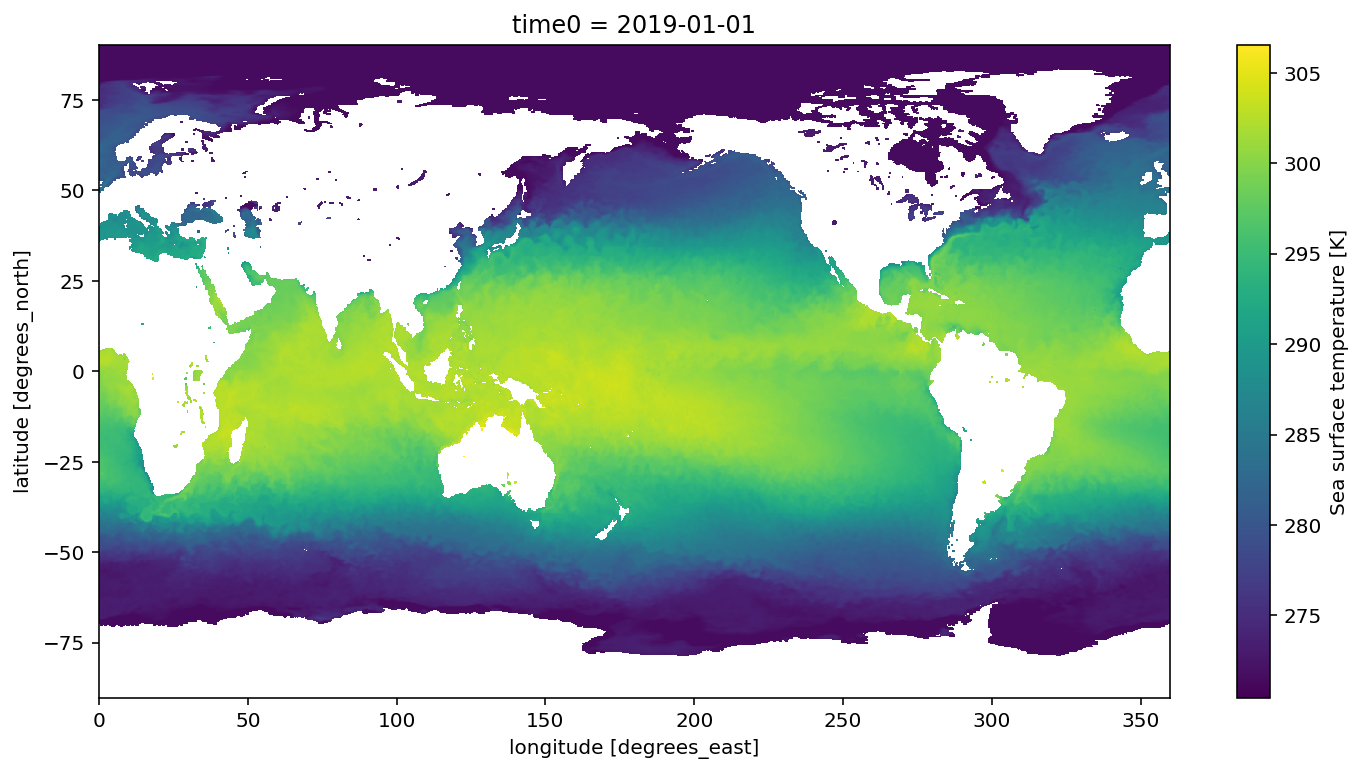

In [6]:
%%time

dy.sea_surface_temperature[0,:,:].plot()

# Change lon from 0 to 360 to -180 to 180

CPU times: user 629 ms, sys: 240 ms, total: 868 ms
Wall time: 6.63 s


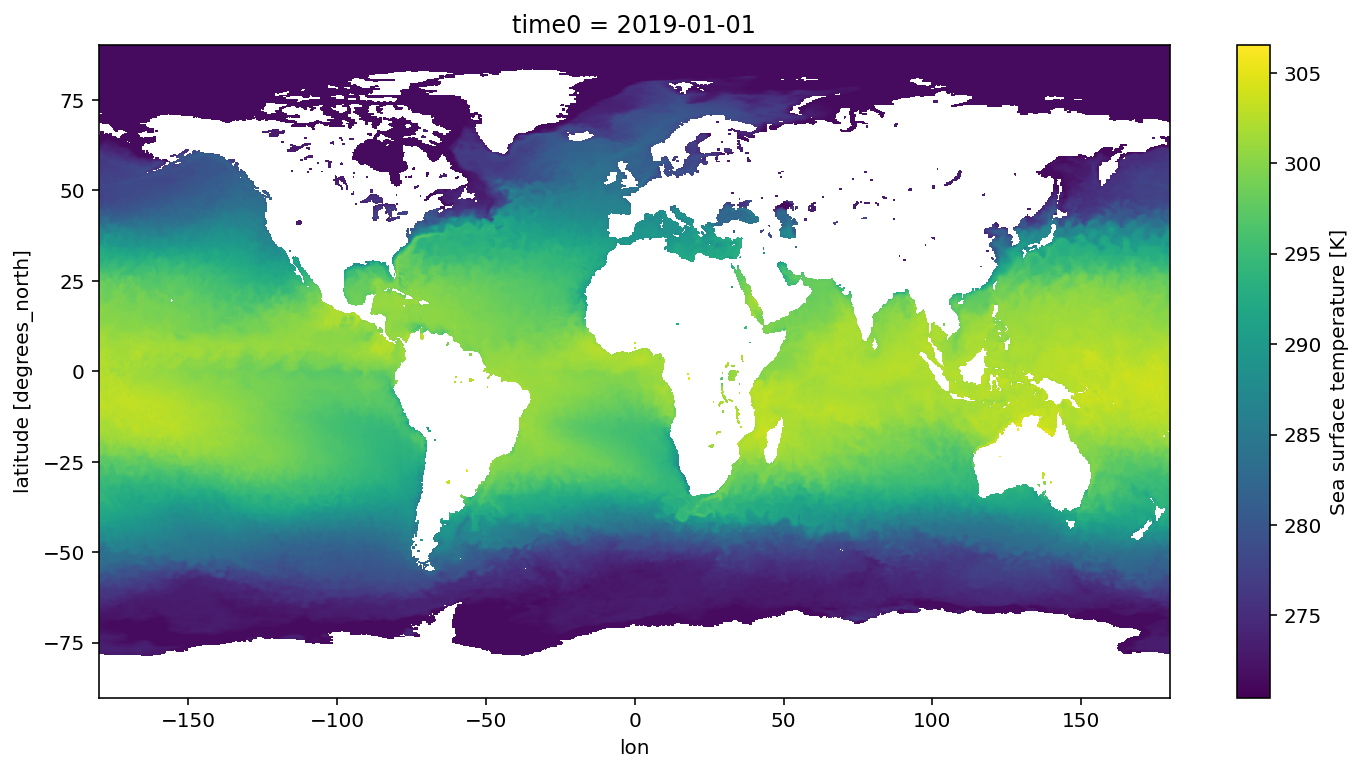

In [7]:
%%time

dy.coords['lon'] = (dy.coords['lon'] + 180) % 360 - 180

dy = dy.sortby(dy.lon)

dy.sea_surface_temperature[0,:,:].plot()